<h1><center>Deep learning with Keras</center></h1>

<center>Owen Jones | Bath ML | 3rd June 2018</center>

Let's start at the very beginning...

In [ ]:
import numpy as np
np.random.seed(2018)

OK yes, that is not the most interesting beginning. But it means that the results in this notebook are now reproducible (yay!). Good. Moving on.

## What is Keras?

> Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. -- **[keras.io](https://keras.io)**

In other words, Keras makes it super easy to build neural networks. And that is exactly what we're going to do.

In [1]:
import keras

C:\Users\jones\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## The best dataset in the world

To get the hang of the Keras syntax, we're going to start off with a really simple network on a really simple dataset. You might have come across this one before...

We're going to be using a little bit of `numpy`, because Keras works with data stored in `numpy` arrays.

In [3]:
iris = np.load("data/iris.npy")
iris

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ],
       [5. , 3.6, 1.4, 0.2, 0. ],
       [5.4, 3.9, 1.7, 0.4, 0. ],
       [4.6, 3.4, 1.4, 0.3, 0. ],
       [5. , 3.4, 1.5, 0.2, 0. ],
       [4.4, 2.9, 1.4, 0.2, 0. ],
       [4.9, 3.1, 1.5, 0.1, 0. ],
       [5.4, 3.7, 1.5, 0.2, 0. ],
       [4.8, 3.4, 1.6, 0.2, 0. ],
       [4.8, 3. , 1.4, 0.1, 0. ],
       [4.3, 3. , 1.1, 0.1, 0. ],
       [5.8, 4. , 1.2, 0.2, 0. ],
       [5.7, 4.4, 1.5, 0.4, 0. ],
       [5.4, 3.9, 1.3, 0.4, 0. ],
       [5.1, 3.5, 1.4, 0.3, 0. ],
       [5.7, 3.8, 1.7, 0.3, 0. ],
       [5.1, 3.8, 1.5, 0.3, 0. ],
       [5.4, 3.4, 1.7, 0.2, 0. ],
       [5.1, 3.7, 1.5, 0.4, 0. ],
       [4.6, 3.6, 1. , 0.2, 0. ],
       [5.1, 3.3, 1.7, 0.5, 0. ],
       [4.8, 3.4, 1.9, 0.2, 0. ],
       [5. , 3. , 1.6, 0.2, 0. ],
       [5. , 3.4, 1.6, 0.4, 0. ],
       [5.2, 3.5, 1.5, 0.2, 0. ],
       [5.2, 3.4, 1.4, 0.2, 0. ],
       [4.7, 3

The first four columns are numeric features (plant-related measurements... don't worry too much), and the fifth column is a label corresponding to the species, which is what we're going to use as our target.

First we're just going to shuffle the rows, because at the moment they're in order (notice the label in the last column); in a minute we'll be splitting the data and we want a mixture of labels in each part.

In [19]:
np.random.shuffle(iris)

Now we'll separate the labels...

In [5]:
iris_labels = iris[:, 4]

... because Keras needs the labels to be "one-hot encoded".

**One-hot encoded label:** list out all the possible labels, and mark the one which is correct.

Here, our label could be 0, 1 or 2. 
    Is it: 0? 1? 2?
    ---------------
    0 =>  [1, 0, 0]
    1 =>  [0, 1, 0]
    2 =>  [0, 0, 1]

Keras can do this for us...

In [6]:
from keras.utils import to_categorical
iris_onehot = to_categorical(iris_labels)
iris_onehot

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0

Now we can get on with building a neural net!

## A simple network

We're going to build a "sequential" model. The clue's in the name - we start with an empty model, and _sequentially_ add layers.

In [7]:
from keras.models import Sequential

model = Sequential()

There are plenty of layers to choose from, and we'll see some more exciting ones later on, but for now we'll stick with dense layers.

For each dense layer, we specify:
* The number of `units`, or how many neurons we want in the layer - the final layer will need to have 3 units, because we're classifying each input as one of 3 labels
* The `activation` function we want to use - in a fully dense network, we tend to use sigmoid activation on the middle layers and softmax on the output layer

And Keras takes care of everything else for us.

Well, almost. For the very first layer in any model, we need to tell Keras what "shape" our input will be. We ignore the first dimension (the number of observations, or "rows"), because it can change without consequence; but we have to specify the other dimensions in a tuple. Here, it's a size-1 tuple, specifying that we have 4 features ("columns").

Oh, and to add layers we use... umm, `add()`.

In [8]:
from keras.layers import Dense

model.add(Dense(15, activation="sigmoid", input_shape=(4,)))
model.add(Dense(3, activation="softmax"))

Let's see what we've created...

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                75        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 48        
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


Looking good!

There's one more thing to do before we can train our model though: now that we're happy with it, we have to lock it in by "compiling" it.

At this point we also need to tell Keras which loss function (always categorical crossentropy for multiclass classification) and optimizer (stochastic gradient descent, or something more fancy) to use.

We can also ask for a list of metrics which we would like to see reported during training. These have nothing to do with the training process. The training process tries to minimise the loss function. Usually that results in an increase in accuracy. Once again - the metrics have NOTHING to do with the training process. It's just nice to see them improving as we train!

In [20]:
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["acc"])

Now we can fit our model! We pass in our training data (remember that the label is in the last column, and we don't want to include that here!) and our one-hot encoded labels, as well as:
* The number of `epochs` to train for, or the total number of times that all our training data gets passed through the network
* A "batch size" - the parameters in the network get updated after each `batch_size` observations have been passed through
* A proportion of the data which we'll set aside and use to assess our model's generalised performance (because a model can usually make great predictions about the data that's been used to train it, but it might not do so well on data it hasn't seen before)

In [21]:
model.fit(iris[:, :4], iris_onehot, epochs=50, batch_size=20, validation_split=0.2)

Train on 120 samples, validate on 30 samples
Epoch 1/50
120/120 [==============================] - 0s 2ms/step - loss: 1.1240 - acc: 0.3583 - val_loss: 1.0803 - val_acc: 0.4000
Epoch 2/50
120/120 [==============================] - 0s 96us/step - loss: 1.1248 - acc: 0.3250 - val_loss: 1.0818 - val_acc: 0.3667
Epoch 3/50
120/120 [==============================] - 0s 138us/step - loss: 1.1231 - acc: 0.3417 - val_loss: 1.0825 - val_acc: 0.3333
Epoch 4/50
120/120 [==============================] - 0s 150us/step - loss: 1.1241 - acc: 0.3250 - val_loss: 1.0834 - val_acc: 0.3667
Epoch 5/50
120/120 [==============================] - 0s 121us/step - loss: 1.1222 - acc: 0.3500 - val_loss: 1.0843 - val_acc: 0.3667
Epoch 6/50
120/120 [==============================] - 0s 142us/step - loss: 1.1232 - acc: 0.3333 - val_loss: 1.0850 - val_acc: 0.3667
Epoch 7/50
120/120 [==============================] - 0s 117us/step - loss: 1.1220 - acc: 0.3167 - val_loss: 1.0852 - val_acc: 0.3667
Epoch 8/50
120/120 [

Notice that the loss keeps dropping, and the accuracy fluctuates but generally speaking increases for both the training and validation sets.

So, that's the syntax, but let's be honest - it's a rubbish boring network and a rubbish boring dataset. Let's move on to something more interesting!

## Look who's walking

Dataset from https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer; see data_prep.ipynb for details on how this data was prepared for use here.

Let's load in the data and check its dimensions, which is always a good thing to do.

In [12]:
walking = np.load("data/walking_data.npy")
walking.shape

(6792, 260, 3)

What? Three dimensions? Rows, columns and... huh??

Don't panic. We have:
* Observations - same as usual!
* Timesteps - each column corresponds to one timestep, and together they form a time series. In this case we have 260 timesteps, forming a time series representing 5 seconds of measurements (because the samples were made at 52Hz).
* Channels - at each timestep there are three values, one for the acceleration measurement in each of the x, y and z directions.

As an important first step, let's work out how to visualise this data. We'll use `matplotlib` for our plotting.

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

We'll plot one observation at a time. One observation is one "row" of our dataset, but remember that every "row" is 3 channels deep. We'll plot each channel individually but on the same graph...

In [14]:
def plot_series(series):
    # x-channel
    plt.plot(series[:, 0], color="red")
    # y-channel
    plt.plot(series[:, 1], color="green")
    # z-channel
    plt.plot(series[:, 2], color="blue")

So now we just pass in one observation from our data (one row, all timesteps and all channels).

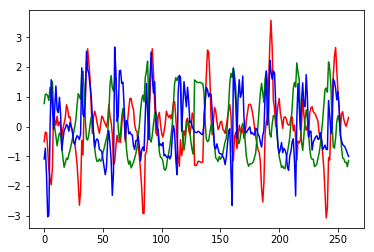

In [17]:
plot_series(walking[100, :, :])

Great! But now we come to an interesting question... can we, intelligent humans, tell between different people's data by eye?

Let's plot a few series for some different people - say, 5 series for 3 people.

![](three.png)

It doesn't look like this is an easy problem for us to solve, even with our big human brains. Maybe the computer will be able to give us a run for our money...


So we have our data; now we need our labels. Each observation comes from one of 15 people so we can quickly check that we have 15 labels.

In [18]:
walking_labels = np.load("data/walking_labels.npy")
set(walking_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

The time has come to split our data, but we'll have to use a slightly different tactic to the `iris` example earlier, because our labels are already separated.

We'll split the row indices into three sets - a 60:20:20 split into training, cross-validation and test sets.

In [23]:
m = walking.shape[0]
indices = [x for x in range(m)]
np.random.shuffle(indices)
train_indices = indices[:int(m*0.6)]
val_indices = indices[int(m*0.6):int(m*0.8)]
test_indices = indices[int(m*0.8):]

Now we can use these indices to partition both our data and our labels, remembering that we need to one-hot encode the labels!

In [25]:
X_train = walking[train_indices, :, :]
X_val = walking[val_indices, :, :]
X_test = walking[test_indices, :, :]

y_train = to_categorical(walking_labels[train_indices])
y_val = to_categorical(walking_labels[val_indices])
y_test = to_categorical(walking_labels[test_indices])

### The neural network

Of course, to start with, we need a model.

In [26]:
model = Sequential()

And we're gonna need some more layers...

In [27]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

Our first layer is going to be a **convolutional layer**. Instead of looking at the whole set of features (timesteps) in one go, this layer looks at a moving "window" of features, so it's great for identifying patterns which are repeated, or pattern which appear often but in not necessarily in the same place every time.

The "dimensionality" of the convolutional window depends on how we want to move this window, which depends on our data. Here, we have time series data, which we can move "along", forwards and backwards, in _one_ dimension; so we use 1D convolution. If we had images instead, we could move the window in _two_ dimensions (left-right and up-down), so it would make more sense to use 2D convolution.

We need to pass some arguments into this convolutional layer:

* `filters`: Like `units` in a dense layer - the number of "features" we want to learn, or number of patterns to try to identify.
* `kernel_size`: The "window" we were just talking about is officially called a **kernel**. We use at a rolling window capturing [`kernel_size`] timesteps at once.
* `strides`: How many time steps to "roll forward" each time we move the window. The larger we set it, the fewer snapshots of our series the kernel will see, so the fewer output neurons will be created.
* `activation`: Just like in the dense layer earlier, except convolutional layers typically use the REctified Linear Unit activation function because it works well and is fast to train
* `input_shape`: Remember, the first layer always needs an input shape so it knows what data it is expecting! This time, we're feeding in observations each of shape ({260 timesteps}, {3 directional acceleration channels})

If we want to get fancy, we can call these arguments **hyperparameters** of our network. The **parameters** are hidden away inside the neurons in each layer, and they get updated during training. The hyperparameters are set by us, and control the shape and behaviour of the network.

In [28]:
model.add(Conv1D(filters=30, kernel_size=40, strides=2, activation="relu", input_shape=(260, 3)))

Next, we'll add a "subsampling" layer. This type of layer groups neurons up based on their position, and then combines them, thereby reducing the number of neurons that pass forward into the next layer.

This has two main effects:
* With fewer neurons, the number of _parameters_ in the following layers of the network is reduced; so there's less updating to be done after each batch, and the network will be less computationally-intensive (i.e. faster!) to train.
* We reduce the chances of learning to recognise super-specific features (and then relying on them later on for our classifications), because we're combining bits and pieces from different neurons. This means our network should generalise better to making predictions on data outside our training set.

We're using "max pooling" as our subsampling tactic, which just takes the strongest neuron from each "pool" (i.e. the one with the highest activation).

In [29]:
model.add(MaxPooling1D(pool_size=2))

But... _why_ have we just added a convolutional layer and then a pooling layer? Why didn't we add another convolutional layer first? Why did we pair neurons up, instead of combining 3 at a time?

These are all valid questions.

The fun, slightly artistic part of building a deep learning model is deciding which layers to add, how big to make them, which hyperparameters to adjust, how to adjust them, when to adjust them, ...

There are a few common rules-of-thumb though. The conv-pool combo we've just seen is very common - convolutional layers add a load of new parameters to the model, and then pooling layers (or other subsampling layers, such as "dropout") strip the new neurons down and help prevent overfitting.

We're going to add another conv-pool pair of layers to our model. The neurons in the first convolutional layer will learn to respond to patterns in our time series data. The neurons in the _second_ convolutional layer will learn to respond to patterns in the (pooled) output of the _first_ layer - so it's responding to _meta-patterns_ in the original data.

In [30]:
model.add(Conv1D(filters=30, kernel_size=10, activation="relu"))
model.add(MaxPooling1D(pool_size=2))

Let's pause for a moment and check the shape of the data which is coming out of the last layer of the network right now.

In [32]:
model.output_shape

(None, 23, 30)

Notice anything?

Yeah, it's still in 3D: some number of rows (which Keras represents with `None`, because we could feed in any number of observations!), some "features" (loosely related to our original timesteps, but twisted beyond recognition by the conv/pool layers), and some "filters" (the number which we set in the latest conv layer).

But if we think about what we want to predict... that's in 2D! Some number of rows, where each one is a one-hot label.

So we somehow need to _flatten_ our network by taking all those stacked-up parameters and laying them out next to each other in a big long line.

This is Keras though, so it's easy to do that...

In [33]:
model.add(Flatten())

And now if we check the shape again:

In [34]:
model.output_shape

(None, 690)

We have the same size of output as before, just reshaped!

Now we can finish off by feeding this into a couple of dense layers. The first one will learn relationships between the now-flattened convolutional neurons, and the second produces the (one-hot) prediction.

In [35]:
model.add(Dense(100, activation="sigmoid"))
model.add(Dense(15, activation="softmax"))

Let's take a step back and admire our handiwork.

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 30)           3630      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 55, 30)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 30)            9030      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 23, 30)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 690)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               69100     
_________________________________________________________________
dense_4 (Dense)              (None, 15)                1515      
Total para

Wow.

In [ ]:
# We have to compile the network before we can run it, defining:
# * Loss function to use (always categorical cross-entropy for multi-class logistic regression)
# * Optimizer to use
#   ("adam" = "ADAptive Movement estimation", but e.g. "sgd" = "Stochastic Gradient Descent" will work, just slower)
# * Metrics to report (NOT used for adjusting parameters - that's what the loss function is for!)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Fit it!
# * X_train and y_train are training data/labels
# * epochs: How many times to pass the training data through and update the network's parameters
# * batch_size: How many observations to include in each batch the optimizer sees
# * Also show us the accuracy for the cross-validation set
model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_val, y_val))

At this point we could try to improve that cross-validation accuracy score, e.g. change network structure.

### Reporting

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_pred = model.predict_classes(X_test)
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

---

## Visualising features

We can try to visualise the "features" of the time series which the convolutional layers of the net have learned to identify.

In [ ]:
# Plot the weights from a given layer
def plot_filter(model, layer, k):
    x = model.layers[layer].get_weights()[0][:, :, k]
    plot_series(x)

In [ ]:
plot_filter(model, 0, 4)

We can also see if there are any patterns in the autocorrelation plots which might suggest strong periodicity.

In [ ]:
def plot_filter_corr(model, layer, k):
    weights = model.layers[layer].get_weights()[0][:, :, k]
    corrs = np.apply_along_axis(lambda y: np.correlate(y, y, mode="full"), 0, weights)
    plot_series(corrs[corrs.shape[0]//2:, :])

In [ ]:
plot_filter_corr(model, 0, 4)

Let's plot each filter with its autocorrelation plot.

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(50, 20))

for k in range(5):
    plt.subplot(2, 5, 1+k)
    plot_filter(model, 0, k)
    plt.subplot(2, 5, 6+k)
    plot_filter_corr(model, 0, k)

In [ ]:
fig.savefig("corrs.png")